<a href="https://colab.research.google.com/github/mark-polo/100DaysOfTriton/blob/main/100DaysOfTriton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install triton

In [2]:
import torch

import triton
import triton.language as tl

# Day 1

In [ ]:
@triton.jit
def _add_kernel(
    x_ptr,
    y_ptr,
    output_ptr,
    num_el,
    BLOCK_SIZE: tl.constexpr
    ):

  pid = tl.program_id(axis=0)

  block_start = pid * BLOCK_SIZE

  offs = block_start + tl.arange(0, BLOCK_SIZE)

  mask = offs < num_el

  x = tl.load(x_ptr + offs, mask=mask)
  y = tl.load(y_ptr + offs, mask=mask)

  output = x + y

  tl.store(output_ptr + offs, output, mask=mask)

In [ ]:
def add(x: torch.Tensor, y: torch.Tensor):

  output = torch.empty_like(x)

  assert x.device == torch.device("cuda:0") and y.device == torch.device("cuda:0") and output.device == torch.device("cuda:0"), f"Tensors have wrong device expected cuda, but got x: {x.device}, y: {y.device} and output: {output.device}"

  num_el = output.numel()

  grid = lambda meta: (triton.cdiv(num_el, meta["BLOCK_SIZE"]),)

  _add_kernel[grid](
      x_ptr      = x,
      y_ptr      = y,
      output_ptr = output,
      num_el     = num_el,
      BLOCK_SIZE = 1024
  )

  return output

In [ ]:
torch.manual_seed(0)
size = 1_000_000
x = torch.rand(size, device="cuda")
y = torch.rand(size, device="cuda")
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([1.0580, 0.6002, 0.3803,  ..., 0.4953, 0.8494, 1.0207], device='cuda:0')
tensor([1.0580, 0.6002, 0.3803,  ..., 0.4953, 0.8494, 1.0207], device='cuda:0')
The maximum difference between torch and triton is 0.0


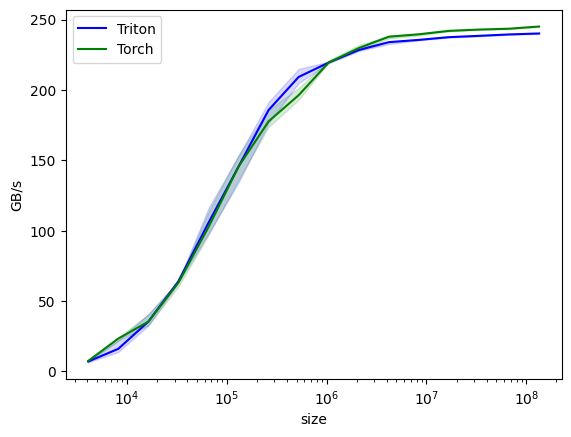

vector-add-performance:
           size      Triton       Torch
0        4096.0    6.981818    7.384615
1        8192.0   15.999999   23.272727
2       16384.0   35.310345   35.310345
3       32768.0   63.999998   63.015384
4       65536.0  105.476395  102.400003
5      131072.0  145.420113  145.420113
6      262144.0  185.654385  177.604328
7      524288.0  209.157447  196.215579
8     1048576.0  219.428568  219.428568
9     2097152.0  228.282153  229.682243
10    4194304.0  233.917907  237.772341
11    8388608.0  235.511559  239.510281
12   16777216.0  237.458234  241.941858
13   33554432.0  238.403038  242.850077
14   67108864.0  239.392948  243.470333
15  134217728.0  240.079781  245.013480


In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device="cuda", dtype=torch.float32)
    y = torch.rand(size, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True)

# Day 2

In [ ]:
@triton.jit
def _relu(
    x_ptr,
    output_ptr,
    num_el,
    BLOCK_SIZE: tl.constexpr
):

  pid = tl.program_id(axis=0)

  block_start = pid * BLOCK_SIZE

  offs = block_start + tl.arange(0, BLOCK_SIZE)

  mask = offs < num_el

  x = tl.load(x_ptr + offs, mask=mask)

  output = tl.maximum(x, 0.0)

  tl.store(output_ptr + offs, output, mask=mask)

In [ ]:
def relu(x: torch.Tensor):
  output = torch.empty_like(x)

  assert x.device == torch.device("cuda:0") and output.device == torch.device("cuda:0"), f"Tensors have wrong device expected cuda, but got x: {x.device} and output: {output.device}"

  num_el = output.numel()

  grid = lambda meta: (triton.cdiv(num_el, meta["BLOCK_SIZE"]),)

  _relu[grid](
      x_ptr      = x,
      output_ptr = output,
      num_el     = num_el,
      BLOCK_SIZE = 1024
  )

  return output

In [ ]:
torch.manual_seed(0)
size = 100_000
x = torch.rand(size, device="cuda")
output_torch = torch.relu(x)
output_triton = relu(x)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([0.3990, 0.5167, 0.0249,  ..., 0.2813, 0.8104, 0.6009], device='cuda:0')
tensor([0.3990, 0.5167, 0.0249,  ..., 0.2813, 0.8104, 0.6009], device='cuda:0')
The maximum difference between torch and triton is 0.0


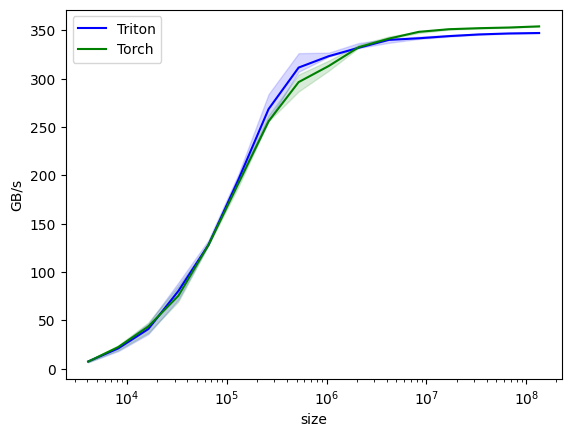

relu-performance:
           size      Triton       Torch
0        4096.0    7.349282    7.245283
1        8192.0   20.897959   22.260869
2       16384.0   40.959998   43.574469
3       32768.0   80.313725   75.386501
4       65536.0  127.999995  127.999995
5      131072.0  195.824709  192.000000
6      262144.0  268.590169  255.999991
7      524288.0  311.581630  296.542993
8     1048576.0  323.368435  313.194740
9     2097152.0  332.108094  332.670041
10    4194304.0  340.225824  341.518617
11    8388608.0  341.908362  348.595753
12   16777216.0  344.133903  351.281743
13   33554432.0  345.879179  352.344086
14   67108864.0  346.899500  353.045990
15  134217728.0  347.363956  354.231202


In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='relu-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.relu(x), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: relu(x), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True)

# Day 3

In [ ]:
@triton.jit
def _relu_fwd(
    x_ptr,
    out_ptr,
    num_el: tl.constexpr,
    BLOCK_SIZE: tl.constexpr
):
  pid = tl.program_id(axis=0)
  start_block = pid * BLOCK_SIZE
  offs = start_block + tl.arange(0, BLOCK_SIZE)

  mask = offs < num_el
  x = tl.load(x_ptr + offs, mask=mask)
  output = tl.maximum(x, 0.0)
  tl.store(out_ptr + offs, output, mask=mask)

@triton.jit
def _relu_bwd(
    x_ptr,
    out_ptr,
    in_ptr,
    num_el: tl.constexpr,
    BLOCK_SIZE: tl.constexpr
):

  pid = tl.program_id(axis=0)
  block_start = pid * BLOCK_SIZE
  offs = block_start + tl.arange(0, BLOCK_SIZE)
  mask = offs < num_el

  x = tl.load(x_ptr + offs, mask=mask)
  grad_output = tl.load(out_ptr + offs, mask=mask)
  grad_input = tl.where(x > 0, grad_output, 0.0)
  tl.store(in_ptr + offs, grad_input, mask=mask)

In [ ]:
class CustomTritonReLU(torch.autograd.Function):

  @staticmethod
  def forward(ctx, x: torch.Tensor):
    output = torch.empty_like(x)
    assert x.device == torch.device("cuda:0") and output.device == torch.device("cuda:0"), f"Tensors have wrong device expected cuda, but got x: {x.device} and output: {output.device}"
    num_el = output.numel()
    grid = lambda meta: (triton.cdiv(num_el, meta["BLOCK_SIZE"]),)

    _relu_fwd[grid](
      x_ptr      = x,
      out_ptr    = output,
      num_el     = num_el,
      BLOCK_SIZE = 1024
    )

    ctx.save_for_backward(x)
    return output

  @staticmethod
  def backward(ctx, grad_out: torch.Tensor):
    x, = ctx.saved_tensors
    num_el = x.numel()
    grad_in = torch.empty_like(x)
    assert x.device == torch.device("cuda:0") and grad_in.device == torch.device("cuda:0"), f"Tensors have wrong device expected cuda, but got x: {x.device} and grad_in: {grad_in.device}"

    grid = lambda meta: (triton.cdiv(num_el, meta["BLOCK_SIZE"]),)

    _relu_bwd[grid](
      x_ptr      = x,
      out_ptr    = grad_out,
      in_ptr     = grad_in,
      num_el     = num_el,
      BLOCK_SIZE = 1024
    )

    return grad_out

In [ ]:
def triton_relu(x: torch.Tensor):
  return CustomTritonReLU.apply(x)

In [ ]:
torch.manual_seed(0)
size = 100_000
x = torch.rand(size, device="cuda", requires_grad=True)

y_triton = triton_relu(x)
loss_triton = y_triton.sum()
loss_triton.backward()

x_torch = x.detach().clone().requires_grad_()
y_torch = torch.relu(x_torch)
loss_torch = y_torch.sum()
loss_torch.backward()

print("Triton and Torch grads")
print(x.grad)
print(x_torch.grad)

print("\nTorch and Triton losses")
print(loss_torch)
print(loss_triton)

print("\nTriton and Torch outputs")
print(y_triton)
print(y_torch)

print("\n")

if torch.allclose(x.grad, x_torch.grad, atol=1e-4):
    print("Triton bwd matches PyTorch")
else:
    print("Error")

Triton and Torch grads
tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')

Torch and Triton losses
tensor(49917.3594, device='cuda:0', grad_fn=<SumBackward0>)
tensor(49917.3594, device='cuda:0', grad_fn=<SumBackward0>)

Triton and Torch outputs
tensor([0.3990, 0.5167, 0.0249,  ..., 0.2813, 0.8104, 0.6009], device='cuda:0',
       grad_fn=<CustomTritonReLUBackward>)
tensor([0.3990, 0.5167, 0.0249,  ..., 0.2813, 0.8104, 0.6009], device='cuda:0',
       grad_fn=<ReluBackward0>)


Triton bwd matches PyTorch


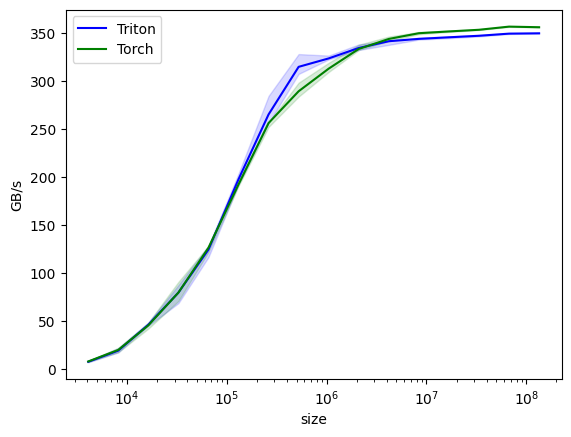

relu-performance-forward:
           size      Triton       Torch
0        4096.0    7.194380    7.547911
1        8192.0   18.846625   19.566879
2       16384.0   45.850746   45.176470
3       32768.0   79.277419   79.277419
4       65536.0  124.121216  126.030769
5      131072.0  197.397587  192.000000
6      262144.0  264.970349  255.999991
7      524288.0  314.572807  289.129413
8     1048576.0  323.368435  312.696613
9     2097152.0  334.225246  333.233892
10    4194304.0  341.296314  343.645205
11    8388608.0  343.720286  349.622453
12   16777216.0  345.380748  351.478001
13   33554432.0  346.966457  353.209501
14   67108864.0  349.185835  356.496821
15  134217728.0  349.525348  355.859147


In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='relu-performance-forward',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.relu(x), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_relu(x), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True)

# Day 4

In [20]:
@triton.jit
def _softmax_fused_kernel(
    x_ptr,
    y_ptr,
    x_stride,
    y_stride,
    num_cols: tl.constexpr,
    BLOCK_SIZE: tl.constexpr
):
  row_idx = tl.program_id(axis=0)
  # The stride represents how much we need to increase the pointer to advance 1 row
  input_row_ptr = x_ptr + row_idx * x_stride
  # Since BLOCK_SIZE is next power of 2, each row can fit in single block
  col_offs = tl.arange(0, BLOCK_SIZE)
  input_row_ptrs = input_row_ptr + col_offs

  mask = col_offs < num_cols
  row = tl.load(input_row_ptrs, mask=mask, other=-float('inf'))
  row_minus_max_for_num_stability = row - tl.max(row, axis=0)

  numerator = tl.exp(row_minus_max_for_num_stability)
  denominator = tl.sum(numerator, axis=0)
  softmax_output = numerator / denominator

  output_row_ptr = y_ptr + row_idx * y_stride
  output_row_ptrs = output_row_ptr + col_offs
  tl.store(output_row_ptrs, softmax_output, mask=mask)

In [15]:
def softmax(x: torch.Tensor):
  num_rows, num_cols = x.shape
  # Round up to the next power of 2 in case if num_cols is not power of 2
  BLOCK_SIZE = triton.next_power_of_2(num_cols)

  # Autotune is gonna replace this
  num_wraps = 4
  if BLOCK_SIZE >= 2048:
    num_wraps = 8
  if BLOCK_SIZE >= 4096:
    num_wraps = 16

  output = torch.empty_like(x)
  assert x.device == torch.device("cuda:0") and output.device == torch.device("cuda:0"), f"Tensors have wrong device expected cuda, but got x: {x.device} and output: {output.device}"

  _softmax_fused_kernel[(num_rows,)](
    x_ptr      = x,
    y_ptr      = output,
    x_stride   = x.stride(0),
    y_stride   = output.stride(0),
    num_cols   = num_cols,
    num_warps  = num_wraps,
    BLOCK_SIZE = BLOCK_SIZE
  )

  return output

In [19]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device="cuda")
output_torch = torch.softmax(x, axis=-1)
output_triton = softmax(x)
print(f"Torch: {output_torch}")
print(f"Triton: {output_triton}")
assert torch.allclose(output_triton, output_torch), f"Results are not close: {(output_triton, output_torch)}"

Torch: tensor([[3.2747e-04, 5.3954e-04, 5.8687e-05,  ..., 5.5490e-04, 2.0330e-04,
         9.4091e-04],
        [8.6914e-04, 1.1075e-03, 1.0202e-04,  ..., 1.1470e-04, 5.5436e-04,
         8.6046e-04],
        [1.4101e-03, 1.0511e-03, 1.7031e-03,  ..., 1.2272e-03, 7.9059e-04,
         3.2380e-04],
        ...,
        [1.0722e-04, 3.6355e-04, 4.1703e-04,  ..., 3.5171e-04, 3.4261e-03,
         1.1834e-03],
        [6.7911e-04, 8.1645e-04, 6.9066e-04,  ..., 1.4361e-04, 9.6083e-04,
         2.5547e-03],
        [5.7850e-04, 9.4147e-04, 1.1231e-04,  ..., 3.4419e-03, 3.8817e-03,
         1.3192e-03]], device='cuda:0')
Triton: tensor([[3.2747e-04, 5.3954e-04, 5.8687e-05,  ..., 5.5490e-04, 2.0330e-04,
         9.4091e-04],
        [8.6914e-04, 1.1075e-03, 1.0202e-04,  ..., 1.1470e-04, 5.5436e-04,
         8.6046e-04],
        [1.4101e-03, 1.0511e-03, 1.7031e-03,  ..., 1.2272e-03, 7.9059e-04,
         3.2380e-04],
        ...,
        [1.0722e-04, 3.6355e-04, 4.1703e-04,  ..., 3.5171e-04, 3.426

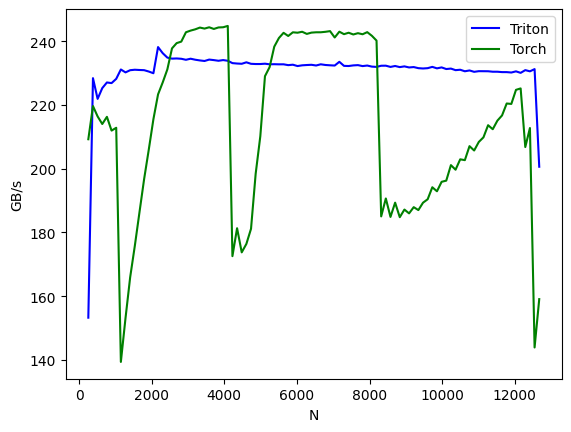

softmax-performance:
          N      Triton       Torch
0     256.0  153.237023  209.222673
1     384.0  228.386528  219.632361
2     512.0  221.890455  216.378650
3     640.0  225.263076  214.003942
4     768.0  227.034749  216.253443
5     896.0  226.837398  211.932117
6    1024.0  228.170799  212.822989
7    1152.0  231.111346  139.358873
8    1280.0  230.198907  153.111934
9    1408.0  230.884869  165.910269
10   1536.0  231.029510  175.746261
11   1664.0  230.951145  186.271992
12   1792.0  230.895557  196.692010
13   1920.0  230.468188  205.930961
14   2048.0  229.930225  215.501260
15   2176.0  238.140874  223.298870
16   2304.0  236.230949  227.041581
17   2432.0  234.837653  231.137529
18   2560.0  234.514737  237.729533
19   2688.0  234.567824  239.378219
20   2816.0  234.467894  239.859505
21   2944.0  234.151612  242.792167
22   3072.0  234.489577  243.308474
23   3200.0  234.174235  243.710208
24   3328.0  233.949174  244.258804
25   3456.0  233.774444  243.943149
26   35

In [17]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device="cuda", dtype=torch.float32)
    stream = getattr(torch, "cuda").Stream()
    getattr(torch, "cuda").set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)